## Machine Learning Project Part -2 TableNet

### 1. Description

TableNet: a novel end-to-end deep learning model for both table detection and structure recognition. The model exploits the interdependence between the twin tasks of table detection and table structure recognition to segment out the table and column regions. This is followed by semantic rule-based row extraction from the identified tabular sub-regions.


Paper: https://arxiv.org/abs/2001.01469


### 2. Problem Statement 

-   The objective is to detect ambiguous tables or nested tables or borderless tables (if present) and localize its structure in an Image
-   To find the start and end of rows and columns from the detected tables. 
-   If Table and its columns are detected, then extract the data using OCR.




### 3. Business Constraints

- Model should detect/ localize Tables and columns with high accuracy. 
- No strict latency requirement

## Data

#### ICDAR : "Robust Reading" refers to the research area dealing with the interpretation of written communication in unconstrained settings. Robust Reading is at the meeting point between camera based document analysis and serves as common ground between the document analysis community and the wider computer vision community.

-    https://rrc.cvc.uab.es/

#### Marmot Dataset : In total, 2000 pages in PDF format were collected and the corresponding ground-truths were extracted utilizing our semi-automatic ground-truthing tool "Marmot". 

-    The dataset is composed of Chinese and English pages at the proportion of about 1: 1  
-                               https://www.icst.pku.edu.cn/cpdp/docs/20190424190300041510.zip 

-     Marmot Extended dataset : https://drive.google.com/drive/folders/1QZiv5RKe3xlOBdTzuTVuYRxixemVIODp
 


## Specific problem

This task will be dealt using semantic segmentation by predicting pixel-wise regions of Table and columns in them

### Performance Metric

Accuracy and F1 Score – we will use both accuracy and F1 Score to take both precision and recall into account, so that False Positives and False Negatives can be reduced. 

### install the required libraries

In [1]:
! pip install seaborn
! pip install opencv-python

### import the libraries

In [3]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

### initializing the required paths

In [4]:
#Data paths

ORIG_DATA_PATH = "C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English"
POSITIVE_DATA_LBL = os.path.join(ORIG_DATA_PATH, 'Positive','Labeled')
DATA_PATH = 'C://Users//malvi//ML_project//table_net//Marmot_data'
PROCESSED_DATA = 'C://Users//malvi//ML_project//table_net//marmot_processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')

### Code Starts from here

In [5]:
#utility functions

# Extract Image coordinate from Marmot dataset
# https://stackoverflow.com/a/58521586

def get_table_bbox(table_xml_path,  new_image_shape):
    
    """
    - Extract Table Coordinates from xml
    - Scale them w.r.t to new image shape
    
    Input:
        table_xml_path: str - xml path
        new_image_shape: tuple - (new_h, new_w)
    
    Output:
        table_bboxes: List 
    """

    tree = ET.parse(table_xml_path)
    root = tree.getroot()

    px0, py1, px1, py0 = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], root.get("CropBox").split()))
    pw = abs(px1 - px0)
    ph = abs(py1 - py0)

    table_bboxes = []

    for table in root.findall(".//Composite[@Label='TableBody']"):
        x0p, y0m, x1p,y1m  = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], table.get("BBox").split()))
        x0 = round(new_image_shape[1]*(x0p - px0)/pw)
        x1 = round(new_image_shape[1]*(x1p - px0)/pw)
        y0 = round(new_image_shape[0]*(py1 - y0m)/ph)
        y1 = round(new_image_shape[0]*(py1 - y1m)/ph)
        
        table_bboxes.append([x0,y0, x1,y1])
    return table_bboxes


def get_col_bbox(column_xml_path, prev_img_shape, new_image_shape, table_bboxes):
    
    """
    - Extract Column Coordinates from xml
    - Scale them w.r.t to new image shape and prev image shape
    - If there are no table_bboxes present , approximate them using column bbox
    
    Input:
        table_xml_path: str - xml path
        prev_img_shape: tuple - (new_h, new_w)
        new_image_shape: tuple - (new_h, new_w)
        table_bboxes: List - list of table bbox coordinates
    
    Output:
        table_bboxes: List 
    """
    
    tree = ET.parse(column_xml_path)
    root = tree.getroot()
    xmins = [round(int(coord.text) * new_image_shape[1] / prev_img_shape[1]) for coord in root.findall("./object/bndbox/xmin")]
    xmaxs = [round(int(coord.text) * new_image_shape[1] / prev_img_shape[1]) for coord in root.findall("./object/bndbox/xmax")]
    ymins = [round(int(coord.text) * new_image_shape[0] / prev_img_shape[0]) for coord in root.findall("./object/bndbox/ymin")]
    ymaxs = [round(int(coord.text) * new_image_shape[0] / prev_img_shape[0]) for coord in root.findall("./object/bndbox/ymax")]

    col_bbox = []
    for x_min, y_min, x_max, y_max in zip(xmins,ymins,xmaxs,ymaxs):
        bbox = [x_min, y_min, x_max, y_max]
        col_bbox.append(bbox)
    
    #fix 1: if no table coord but have column coord
    if len(table_bboxes) == 0:
        thresh = 3
        x_min = min([x[0] for x in col_bbox]) - thresh 
        y_min = min([x[1] for x in col_bbox]) - thresh 
        x_max = max([x[2] for x in col_bbox]) + thresh  
        y_max = max([x[3] for x in col_bbox]) + thresh 
        
        table_bboxes = [[x_min, y_min, x_max, y_max]]
    
    return col_bbox, table_bboxes

def create_mask(new_h, new_w, bboxes = None):
    
    """
    - create a mask based on new_h, new_w and bounding boxes
    
    Input:
        new_h: int - height of the mask
        new_w: int - width of the mask
        bboxes: List - bounding box coordinates  
    
    Output:
        mask: Image 
    """
    
    mask = np.zeros((new_h, new_w), dtype=np.int32)
    
    if bboxes is None or len(bboxes)==0:
         return Image.fromarray(mask)
    
    for box in bboxes:
        mask[box[1]:box[3], box[0]:box[2]] = 255
    
    return Image.fromarray(mask)

## Exploratory Data Analysis

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [6]:
pos_data = glob.glob('C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0/data/English/Positive/Raw' + '/*.bmp')
neg_data = glob.glob('C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0/data/English/Negative/Raw' + '/*.bmp')

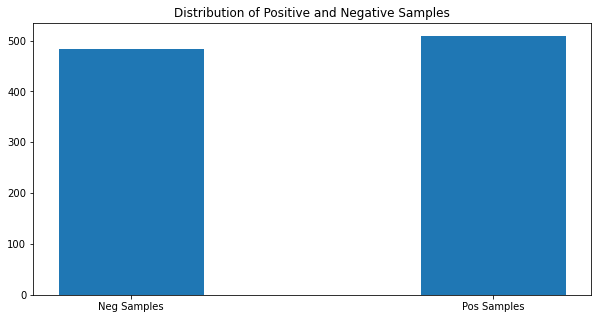

In [7]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
y = [len(neg_data), len(pos_data)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Observations:
- It is clear that there is no data imbalance problem

### 1. Negative sample will not contain any Table

In [8]:
new_h, new_w = 1024, 1024

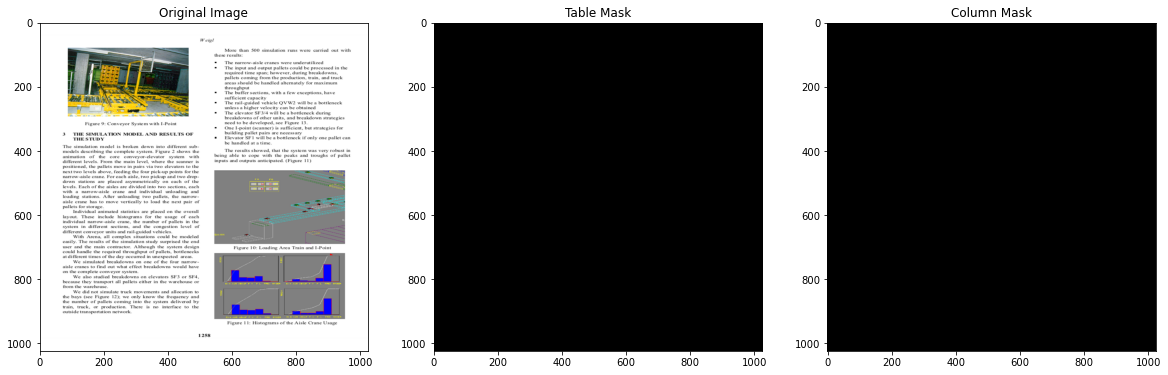

In [9]:
#Negative example - 1

img_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Negative//Raw//10.1.1.1.2000_4.bmp'
image = Image.open(img_path)

#resize image 1024, 1024
image = image.resize((new_h, new_w))

table_mask = create_mask(new_h, new_w)
col_mask = create_mask(new_h, new_w)


f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

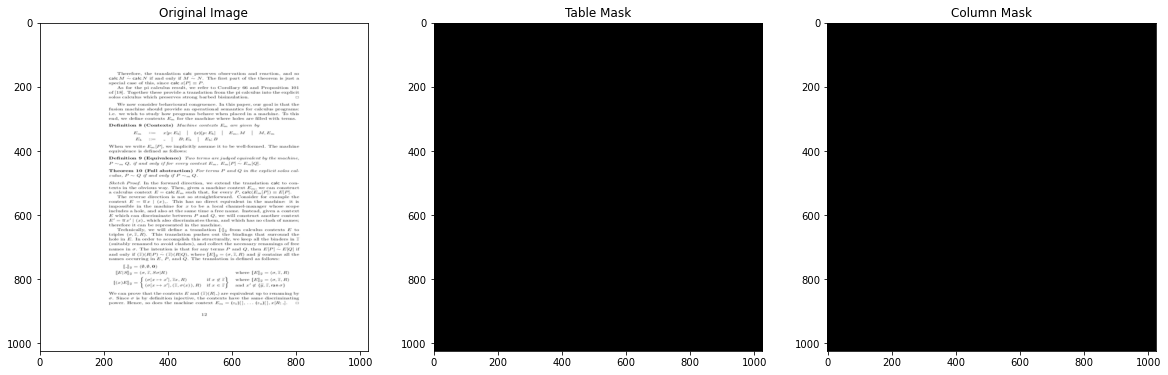

In [10]:
#Negative example - 2

img_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Negative//Raw//10.1.1.1.2016_12.bmp'
image = Image.open(img_path)

#resize imageto std 1024, 1024
image = image.resize((new_h, new_w))

table_mask = create_mask(new_h, new_w)
col_mask = create_mask(new_h, new_w)


f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

- There are figures which looks like tables but are not,
- Trained model should be able to differentiate between them

### 2. Positive Sample

In [11]:
#positive example

img_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Positive//Raw//10.1.1.1.2006_3.bmp'
table_xml_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Positive//Labeled//10.1.1.1.2006_3.xml'
column_xml_path = 'C://Users//malvi//ML_project//table_net//Marmot_data//10.1.1.1.2006_3.xml'

In [12]:
#load image
image = Image.open(img_path)

#resize imageto std 1024, 1024
w, h = image.size
image = image.resize((new_h, new_w))

#convert to 3 channel image if 1 channel
if image.mode != 'RGB':
    image = image.convert("RGB")

#scaled versions of bbox coordinates of table
table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))

#scaled versions of bbox coordinates of columns
col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)

In [13]:
col_bboxes

[[591, 647, 668, 716],
 [686, 647, 733, 714],
 [753, 649, 799, 716],
 [823, 649, 865, 715]]

In [14]:
table_bboxes

[[585, 649, 878, 715]]

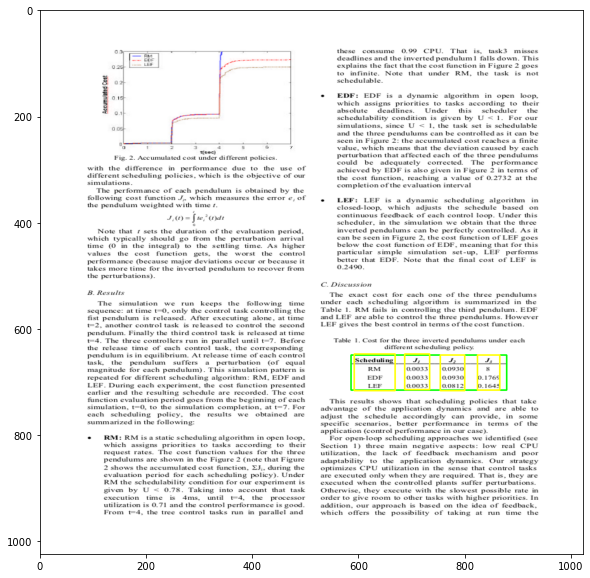

In [15]:
plt.figure(figsize = (20,10))

image_temp = np.array(image).copy()
for bbox in table_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

for bbox in col_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 0), 2)
    
plt.imshow(image_temp)

In [16]:
table_mask = create_mask(new_h, new_w, table_bboxes)
col_mask = create_mask(new_h, new_w, col_bboxes)

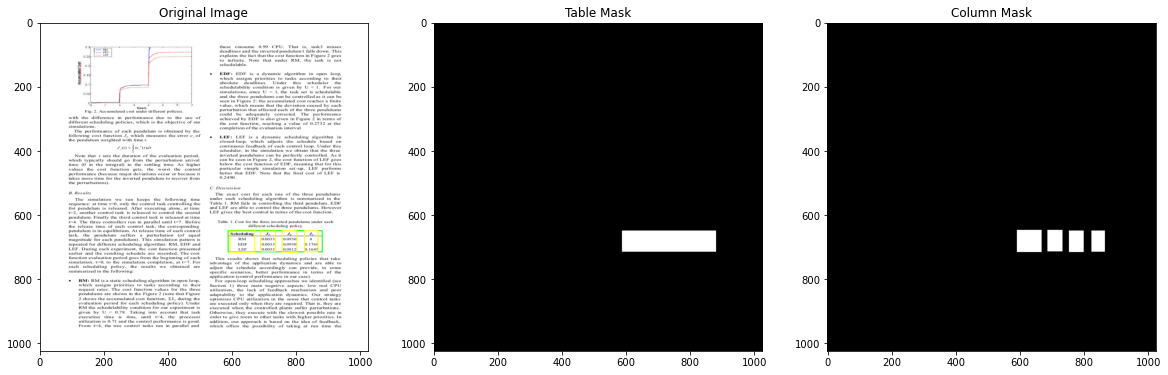

In [17]:
f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image_temp))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

In [18]:
#positive example -2

img_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Positive//Raw//10.1.1.8.2182_6.bmp'
table_xml_path = 'C://Users//malvi//ML_project//table_net//marmot_dataset_v1.0//data//English//Positive//Labeled//10.1.1.8.2182_6.xml'
column_xml_path = 'C://Users//malvi//ML_project//table_net//Marmot_data/10.1.1.8.2182_6.xml'

In [19]:
#load image
image = Image.open(img_path)

#resize imageto std 1024, 1024
w, h = image.size
image = image.resize((new_h, new_w))

#convert to 3 channel image if 1 channel
if image.mode != 'RGB':
    image = image.convert("RGB")

#scaled versions of bbox coordinates of table
table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))

In [20]:
table_bboxes

[]

No table bounding box for this image from orginal Marmot dataset, we will approximate it using Column Bounding Box

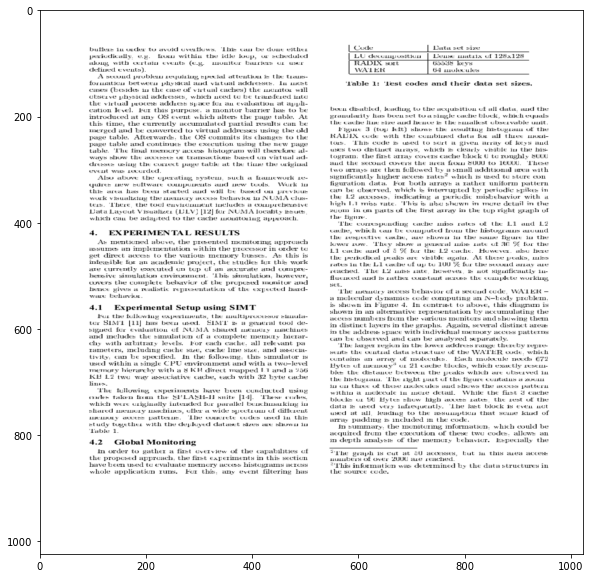

In [21]:
plt.figure(figsize = (20,10))
plt.imshow(np.array(image))
plt.show()

- We can see that the table is partially visible 
- and for this positive sample, original dataset has no table coordinates
- Since there are column coordinates present in extended version of this dataset, we will use column coordinates to get table coordinates

In [22]:
#scaled versions of bbox coordinates of columns
col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)

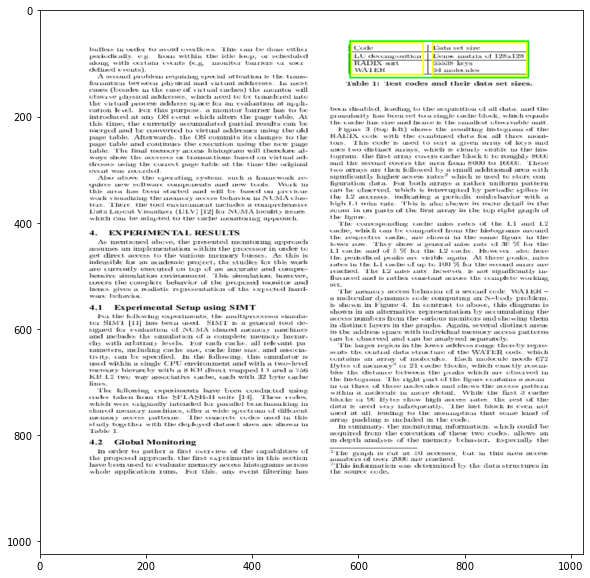

In [23]:
 plt.figure(figsize = (20,10))

image_temp = np.array(image).copy()
for bbox in table_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

for bbox in col_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 0), 2)
    
plt.imshow(image_temp)

In [24]:
table_mask = create_mask(new_h, new_w, table_bboxes)
col_mask = create_mask(new_h, new_w, col_bboxes)

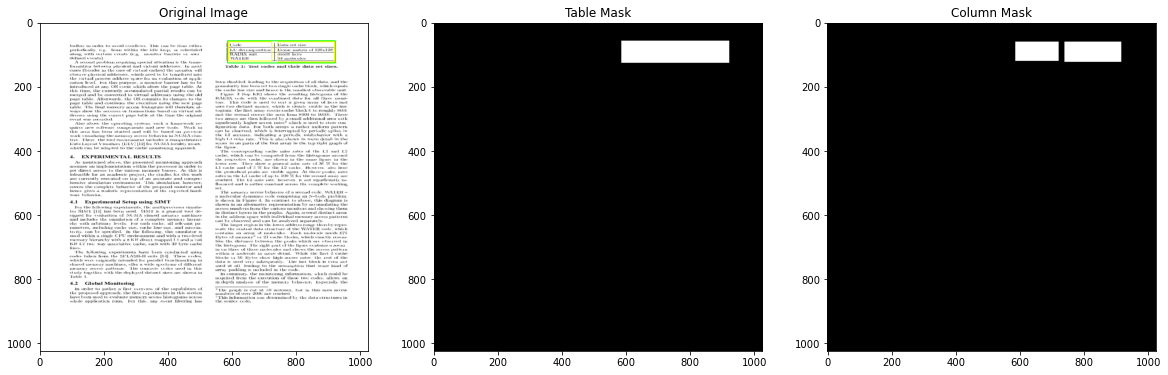

In [25]:
f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image_temp))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

### Observations based on EDA

- There are many figures in the images which looks like tables but are not,
- Model should be able to differentiate between them
- For Negative Samples , we will have masks with no activated pixels
- There are images with no predefined table bounding box coordinates from original dataset, but has column bounding box coordinates from extended version of the dataset.
- In such cases we will use column coordinates to approximate Table coordinates. 


## Data Preprocessing

In [26]:
#make directories to save data

os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [27]:
new_h, new_w = 1024, 1024

In [28]:
processed_data = []

for i, data in enumerate([neg_data, pos_data]):
    
    for j, img_path in tqdm(enumerate(data)):
        
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        table_bboxes, col_bboxes = [], []
        
        if i == 1:
            
            #get xml filename
            xml_file = image_name.replace('bmp', 'xml')
            table_xml_path = os.path.join(POSITIVE_DATA_LBL, xml_file)
            column_xml_path = os.path.join(DATA_PATH,xml_file)
            
            #get table boxes
            table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))
            
            #get column boxes , if table boxes are empty, approximate them using column boxes
            if os.path.exists(column_xml_path):
                col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)
            else:
                col_bboxes = []
        
        #generate masks
        table_mask = create_mask(new_h, new_w, table_bboxes)
        col_mask = create_mask(new_h, new_w, col_bboxes)
        
        #save images and masks
        save_image_path = os.path.join(IMAGE_PATH, image_name.replace('bmp', 'jpg'))
        save_table_mask_path = os.path.join(TABLE_MASK_PATH, image_name[:-4] + '_table_mask.png')
        save_col_mask_path = os.path.join(COL_MASK_PATH, image_name[:-4] + '_col_mask.png')
        
        image.save(save_image_path)
        table_mask.save(save_table_mask_path)
        col_mask.save(save_col_mask_path)
        
        #add data to dataframe
        len_table = len(table_bboxes)
        len_cols = len(col_bboxes)

        value = (save_image_path, save_table_mask_path, save_col_mask_path, h, w, int(len_table != 0), \
                 len_table, len_cols, table_bboxes, col_bboxes)
        
        processed_data.append(value)


484it [00:32, 15.10it/s]
509it [00:40, 12.54it/s]


In [29]:
column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
processed_data = pd.DataFrame(processed_data, columns=column_name)

In [30]:
processed_data.to_csv("processed_data.csv", index = False)

In [31]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1008,768,0,0,0,[],[]
1,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1123,793,0,0,0,[],[]
2,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1123,793,0,0,0,[],[]
3,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,0,0,0,[],[]
4,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,0,0,0,[],[]


In [32]:
# storing the processed data
processed_data = pd.read_csv('processed_data.csv')

In [33]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1008,768,0,0,0,[],[]
1,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1123,793,0,0,0,[],[]
2,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1123,793,0,0,0,[],[]
3,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,0,0,0,[],[]
4,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,0,0,0,[],[]


## Advanced EDA

In [34]:
processed_data['hasTable'].value_counts().tolist()

[499, 494]

#### Positive : Negative Ratio

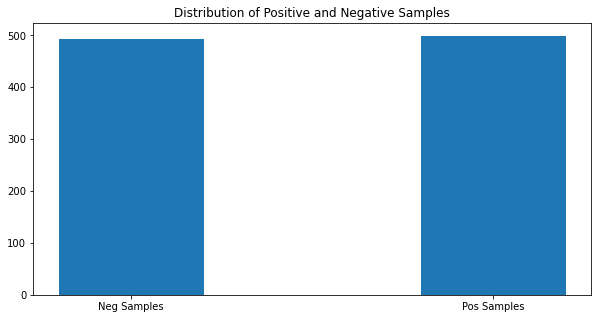

In [35]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [36]:
processed_data[(processed_data['table_count']==0) & (processed_data['col_count']!=0)]

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes


#### Table with No Columns

In [37]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
485,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1008,768,1,2,0,"[[68, 494, 484, 602], [536, 804, 949, 912]]",[]
550,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,1,2,0,"[[138, 622, 693, 891], [138, 99, 693, 440]]",[]
703,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1123,793,1,1,0,"[[65, 183, 936, 850]]",[]
957,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,1,1,0,"[[516, 611, 885, 734]]",[]
958,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,C://Users//malvi//ML_project//table_net//marmo...,1056,816,1,3,0,"[[133, 171, 501, 310], [133, 419, 501, 734], [...",[]


#### plotting image with table but no columns

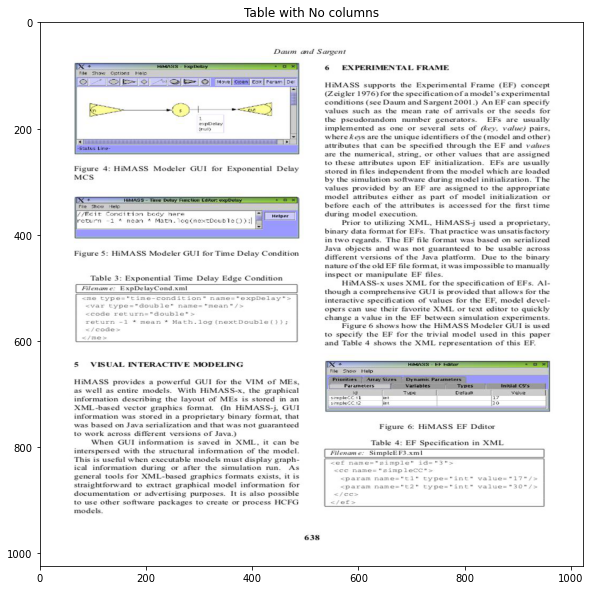

In [38]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

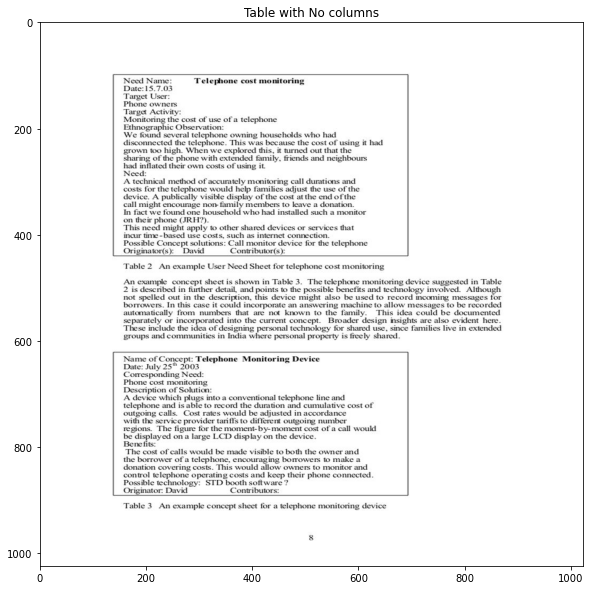

In [39]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

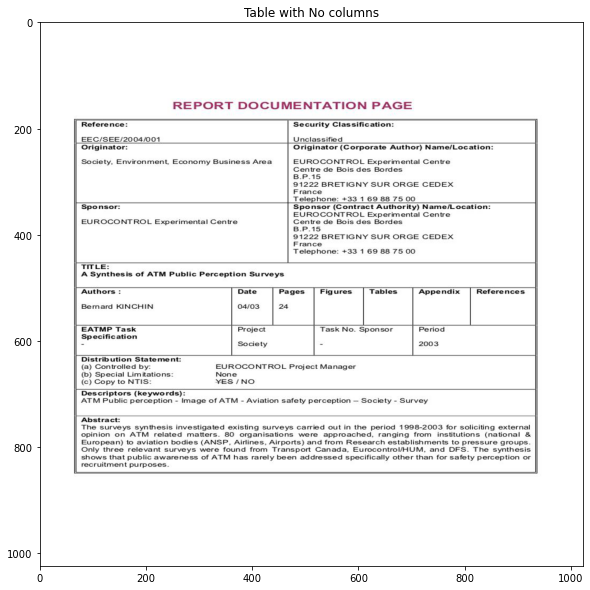

In [40]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

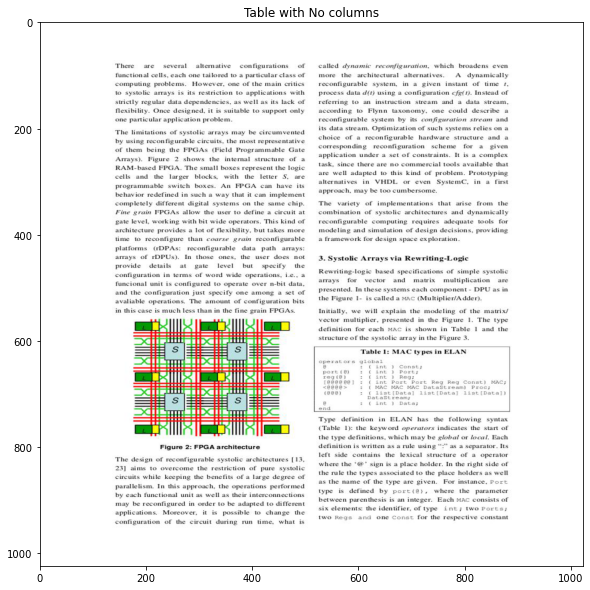

In [41]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

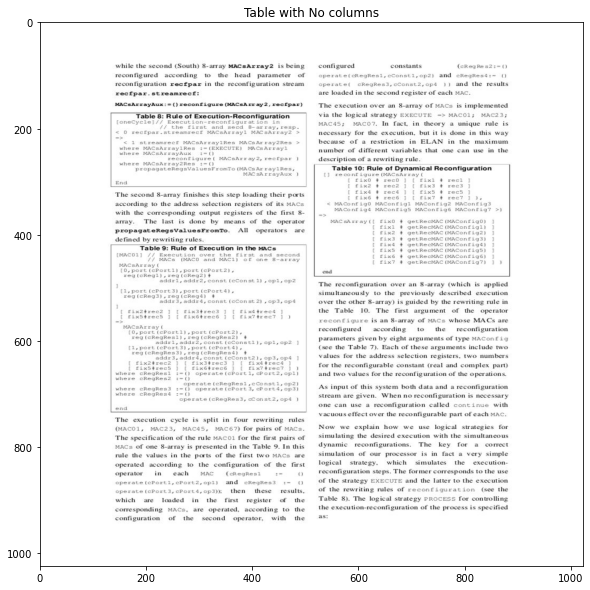

In [42]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

<AxesSubplot:ylabel='Frequency'>

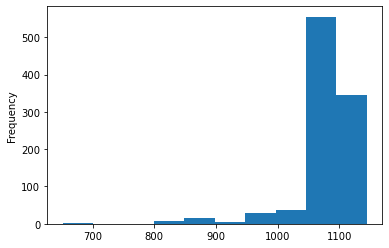

In [43]:
processed_data['original_height'].plot.hist(bins = 10)

In [74]:
! pip install seaborn==0.12.0

  Using cached seaborn-0.12.0-py3-none-any.whl (285 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


### Width of the Image

<AxesSubplot:ylabel='Frequency'>

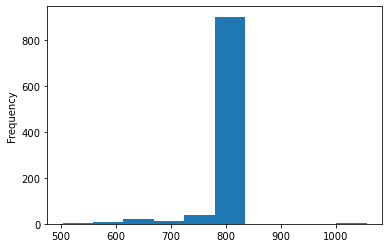

In [76]:
processed_data['original_width'].plot.hist(bins = 10)

### Total Tables

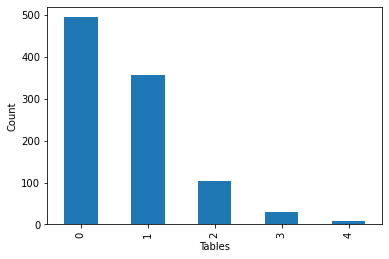

In [78]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

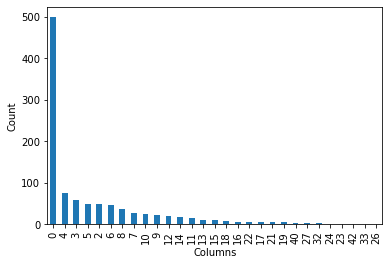

In [79]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.